In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable, join
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle
import emcee

from scipy.interpolate import interp1d
from pandas import DataFrame as df

In [2]:
# Load Full Data
full_ideal_res = QTable.read("Data/Full_Ideal_CloudyResults_wNHII.fits")

# Load Colissional Models of Gnat+2007
CIE = QTable.read("Data/CIEModels.fits")
ISOB = QTable.read("Data/ISOBModels.fits")
ISOCh = QTable.read("Data/ISOChModels.fits")

In [3]:
ISOCh["LOG_CIV/SiIV"].mask |= np.isinf(ISOCh["LOG_CIV/SiIV"])
ISOB["LOG_CIV/SiIV"].mask |= np.isinf(ISOB["LOG_CIV/SiIV"])
CIE["LOG_CIV/SiIV"].mask |= np.isinf(CIE["LOG_CIV/SiIV"])

In [4]:
ISOCh_interper = interp1d(np.log10(ISOCh["T"].value)[~ISOCh["LOG_CIV/SiIV"].mask],
                          ISOCh["LOG_CIV/SiIV"].data[~ISOCh["LOG_CIV/SiIV"].mask], 
                          fill_value = np.nan, 
                          bounds_error = False)

ISOB_interper = interp1d(np.log10(ISOB["T"].value)[~ISOB["LOG_CIV/SiIV"].mask],
                          ISOB["LOG_CIV/SiIV"].data[~ISOB["LOG_CIV/SiIV"].mask], 
                          fill_value = np.nan, 
                          bounds_error = False)

CIE_interper = interp1d(np.log10(CIE["T"].value)[~CIE["LOG_CIV/SiIV"].mask],
                          CIE["LOG_CIV/SiIV"].data[~CIE["LOG_CIV/SiIV"].mask], 
                          fill_value = np.nan, 
                          bounds_error = False)

In [5]:
vel_mask = full_ideal_res["MEAS_V_CIV"]>150*u.km/u.s

not_photo_mask = full_ideal_res["N_CIV"]/full_ideal_res["MEAS_N_CIV"] < .1
not_photo_mask &= full_ideal_res["N_SiIV"]/full_ideal_res["MEAS_N_SiIV"] < .1

full_ideal_res = full_ideal_res[vel_mask & not_photo_mask]

In [6]:
good_col_meas_mask = (full_ideal_res["CIV_to_SiIV_BAD"] | 
                  full_ideal_res["CIV_to_SiIV_LL"] | 
                  full_ideal_res["CIV_to_SiIV_UL"])

good_col_meas_mask = np.invert(good_col_meas_mask)



good_b_CIV = ~np.isnan(full_ideal_res["B_CIV"])
good_b_SiIV = ~np.isnan(full_ideal_res["B_SiIV"])

useable_mask = good_col_meas_mask | good_b_CIV | good_b_SiIV

In [7]:
use_log_ratio = full_ideal_res[useable_mask]["CIV_to_SiIV"]
use_log_ratio_err = full_ideal_res[useable_mask]["CIV_to_SiIV_err"]


use_b_CIV = full_ideal_res[useable_mask]["B_CIV"]
use_b_CIV_err = full_ideal_res[useable_mask]["ERR_B_CIV"]

use_b_SiIV = full_ideal_res[useable_mask]["B_SiIV"]
use_b_SiIV_err = full_ideal_res[useable_mask]["ERR_B_SiIV"]


In [8]:
Y = np.vstack([use_log_ratio, use_b_CIV, use_b_SiIV])
Y_err = np.vstack([use_log_ratio_err, use_b_CIV_err, use_b_SiIV_err])


Y_masked = np.ma.masked_array(data = Y, mask = np.isnan(Y)|np.isnan(Y_err))
Y_err_masked = np.ma.masked_array(data = Y_err, mask = np.isnan(Y)|np.isnan(Y_err))

In [101]:
Y.shape

(3, 33)

In [10]:
from astropy.constants import m_p, k_B

def line_width(temperature, mass, turbulence):
    """
    Modeled Line width
    """
    return np.sqrt(2) * np.sqrt(2 * k_B * temperature / 
                   mass + turbulence**2).to(u.km/u.s)

# Set Masses
mass_C = 12.0107 * u.u
mass_Si = 28.0855 * u.u


def log_likelihood_CIE(theta): 
    """
    XXXXXXXX
    """
    log_T_e, turbulence = theta
    T_e = 10**log_T_e
    model_C_lw = line_width(T_e * u.K, mass_C, turbulence * u.km/u.s).value
    model_Si_lw = line_width(T_e * u.K, mass_Si, turbulence * u.km/u.s).value
    
    CIE_ratio = CIE_interper(log_T_e)
    
    model = np.vstack([[CIE_ratio, model_C_lw, model_Si_lw]]).T
    sigma2 = Y_err_masked ** 2
    return -0.5 * np.ma.sum((Y_masked - model) ** 2 / sigma2 + np.log(sigma2))


def log_likelihood_ISOB(theta): 
    """
    XXXXXXXX
    """
    log_T_e, turbulence = theta
    T_e = 10**log_T_e
    model_C_lw = line_width(T_e * u.K, mass_C, turbulence * u.km/u.s).value
    model_Si_lw = line_width(T_e * u.K, mass_Si, turbulence * u.km/u.s).value
    
    ISOB_ratio = ISOB_interper(log_T_e)
    
    model = np.vstack([[ISOB_ratio, model_C_lw, model_Si_lw]]).T
    sigma2 = Y_err_masked ** 2
    return -0.5 * np.ma.sum((Y_masked - model) ** 2 / sigma2 + np.log(sigma2))

def log_likelihood_ISOCh(theta): 
    """
    XXXXXXXX
    """
    log_T_e, turbulence = theta
    T_e = 10**log_T_e
    model_C_lw = line_width(T_e * u.K, mass_C, turbulence * u.km/u.s).value
    model_Si_lw = line_width(T_e * u.K, mass_Si, turbulence * u.km/u.s).value
    
    ISOCh_ratio = ISOCh_interper(log_T_e)
    
    model = np.vstack([[ISOCh_ratio, model_C_lw, model_Si_lw]]).T
    sigma2 = Y_err_masked ** 2
    return -0.5 * np.ma.sum((Y_masked - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior_CIE(theta):
    log_T_e, turbulence = theta
#     ISOCh_ratio = ISOCh_interper(log_T_e)
#     ISOB_ratio = ISOB_interper(log_T_e)
    CIE_ratio = CIE_interper(log_T_e)
    
    if np.isnan(CIE_ratio):
        return -np.inf
    elif turbulence < 0:
        return -np.inf
    else:
        return 0.0
    
def log_prior_ISOB(theta):
    log_T_e, turbulence = theta
#     ISOCh_ratio = ISOCh_interper(log_T_e)
    ISOB_ratio = ISOB_interper(log_T_e)
#     CIE_ratio = CIE_interper(log_T_e)
    
    if np.isnan(ISOB_ratio):
        return -np.inf
    elif turbulence < 0:
        return -np.inf
    else:
        return 0.0
    
def log_prior_ISOCh(theta):
    log_T_e, turbulence = theta
    ISOCh_ratio = ISOCh_interper(log_T_e)
#     ISOB_ratio = ISOB_interper(log_T_e)
#     CIE_ratio = CIE_interper(log_T_e)
    
    if np.isnan(ISOCh_ratio):
        return -np.inf
    elif turbulence < 0:
        return -np.inf
    else:
        return 0.0
    
    
def log_prob_CIE(theta):
    return log_prior_CIE(theta) + log_likelihood_CIE(theta)

def log_prob_ISOCh(theta):
    return log_prior_ISOCh(theta) + log_likelihood_ISOCh(theta)

def log_prob_ISOB(theta):
    return log_prior_ISOB(theta) + log_likelihood_ISOB(theta)

In [11]:
log_prior_CIE([4.6, 18])

0.0

In [12]:
import multiprocessing as mp
mp.set_start_method('fork')

In [13]:
from multiprocessing import Pool

In [14]:
pos = np.random.rand(150,2) * [5.8-4.6,25]
pos[:,0] += 4.6
nwalkers, ndim = pos.shape

with Pool() as pool:

    sampler_CIE = emcee.EnsembleSampler(nwalkers, 
                                    ndim, 
                                    log_prob_CIE, 
                                        pool = pool)
    sampler_CIE.run_mcmc(pos, 10000, 
                     progress=True)


100%|█████████████████████████████████████| 10000/10000 [04:07<00:00, 40.45it/s]


<IPython.core.display.Javascript object>


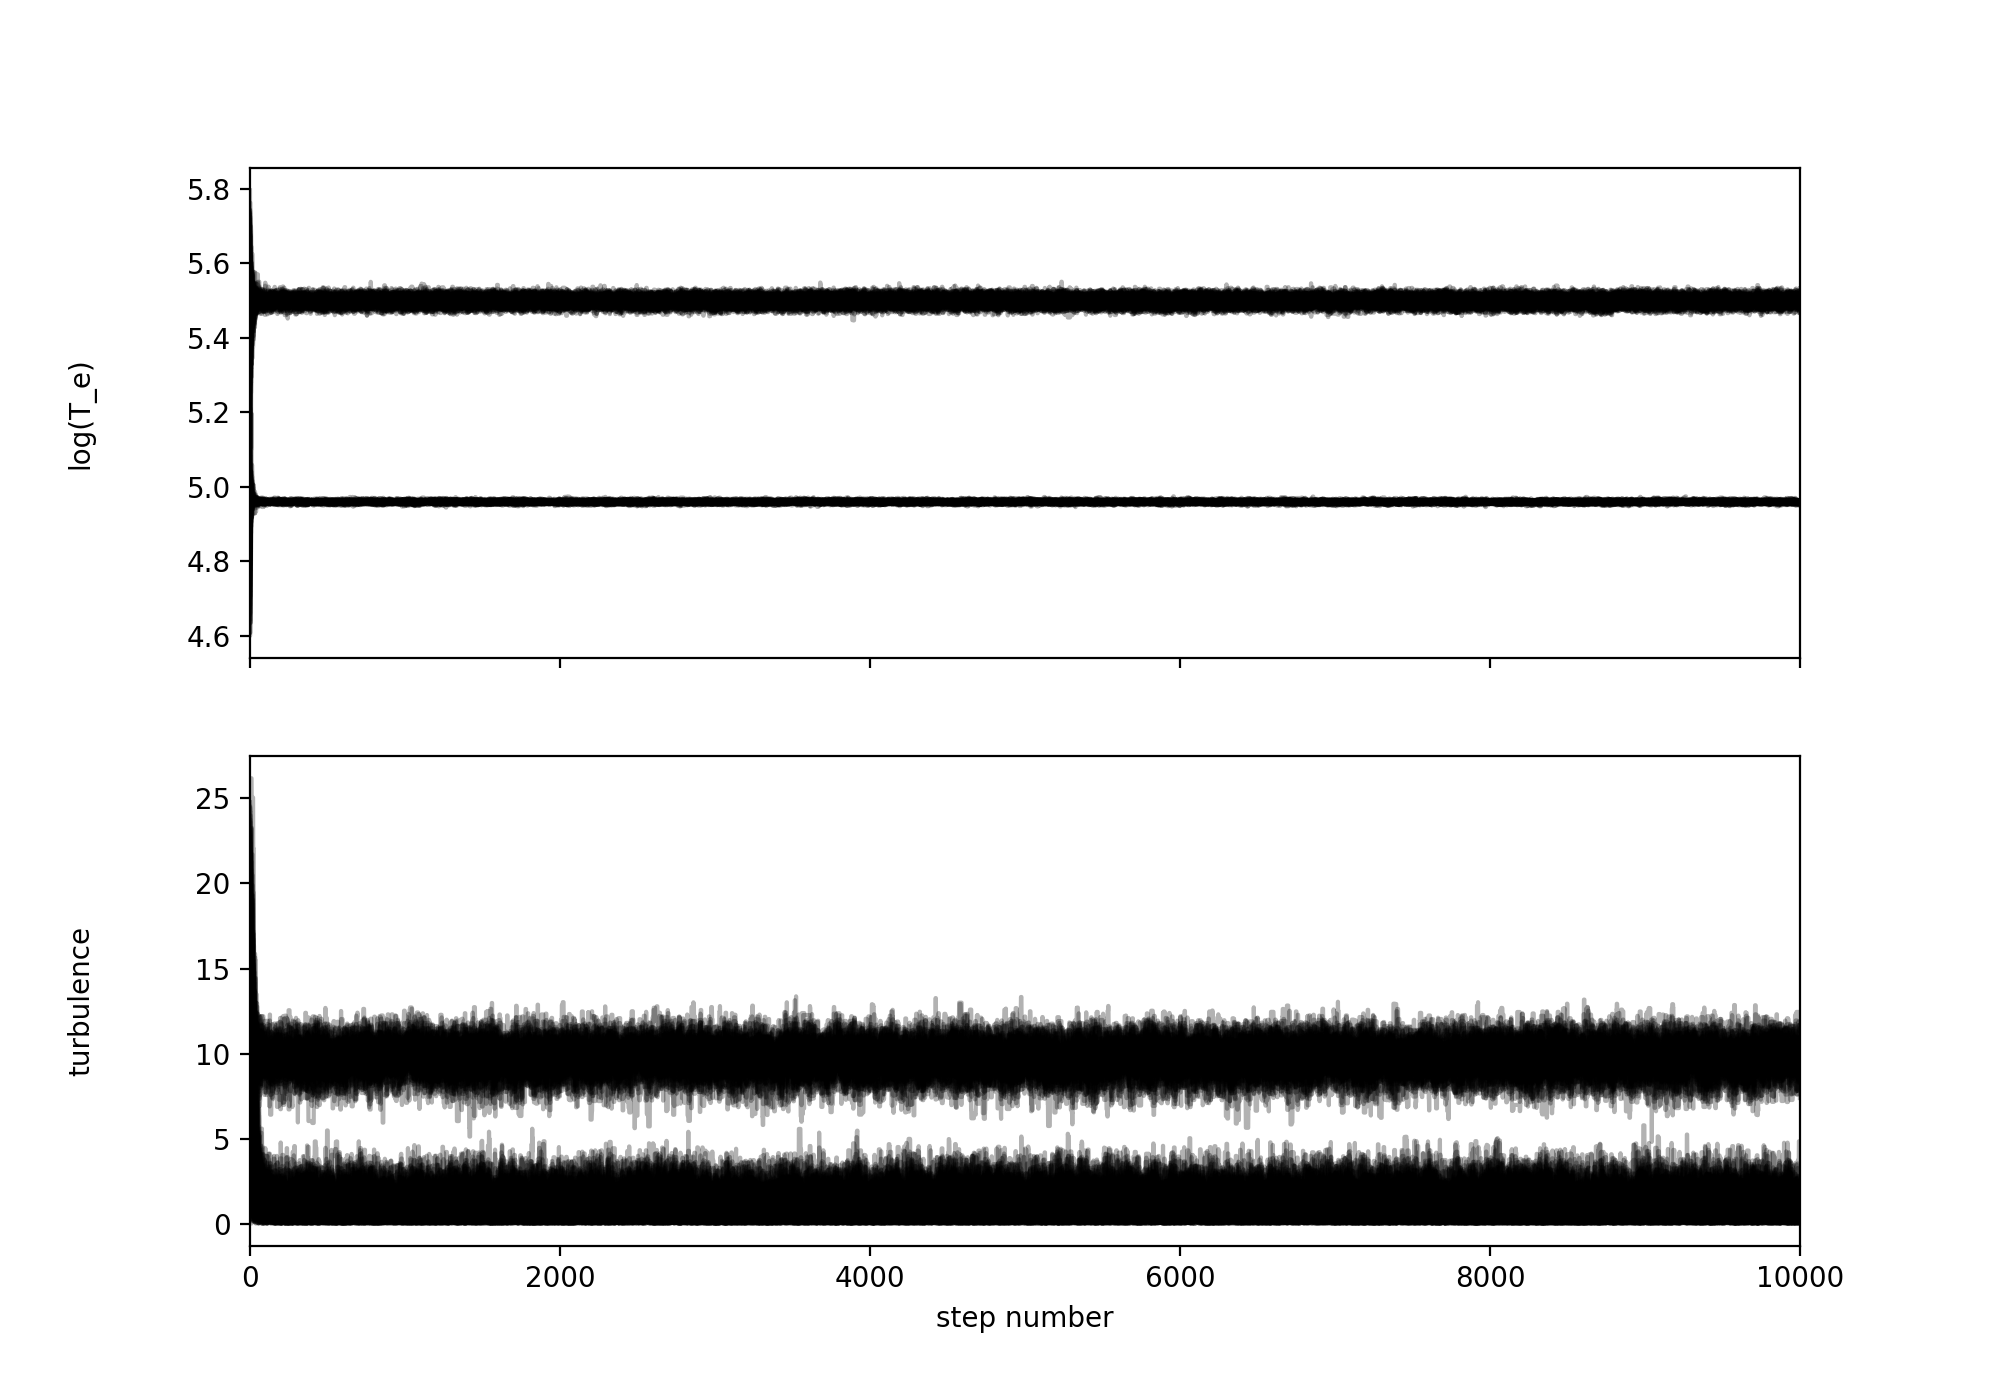

In [17]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples_CIE = sampler_CIE.get_chain()
labels = ["log(T_e)", "turbulence"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_CIE[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_CIE))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [245]:
tau = sampler_CIE.get_autocorr_time()
print(tau)

[36.84955619 64.47100674]


In [18]:
flat_samples_CIE = sampler_CIE.get_chain(discard=100, thin=15, flat=True)
data_CIE = df(flat_samples_CIE, columns=[r"$\log_{10}(T_e/\mathrm{K})$", r"$\sigma_\mathrm{nonThermal}$"])

<IPython.core.display.Javascript object>


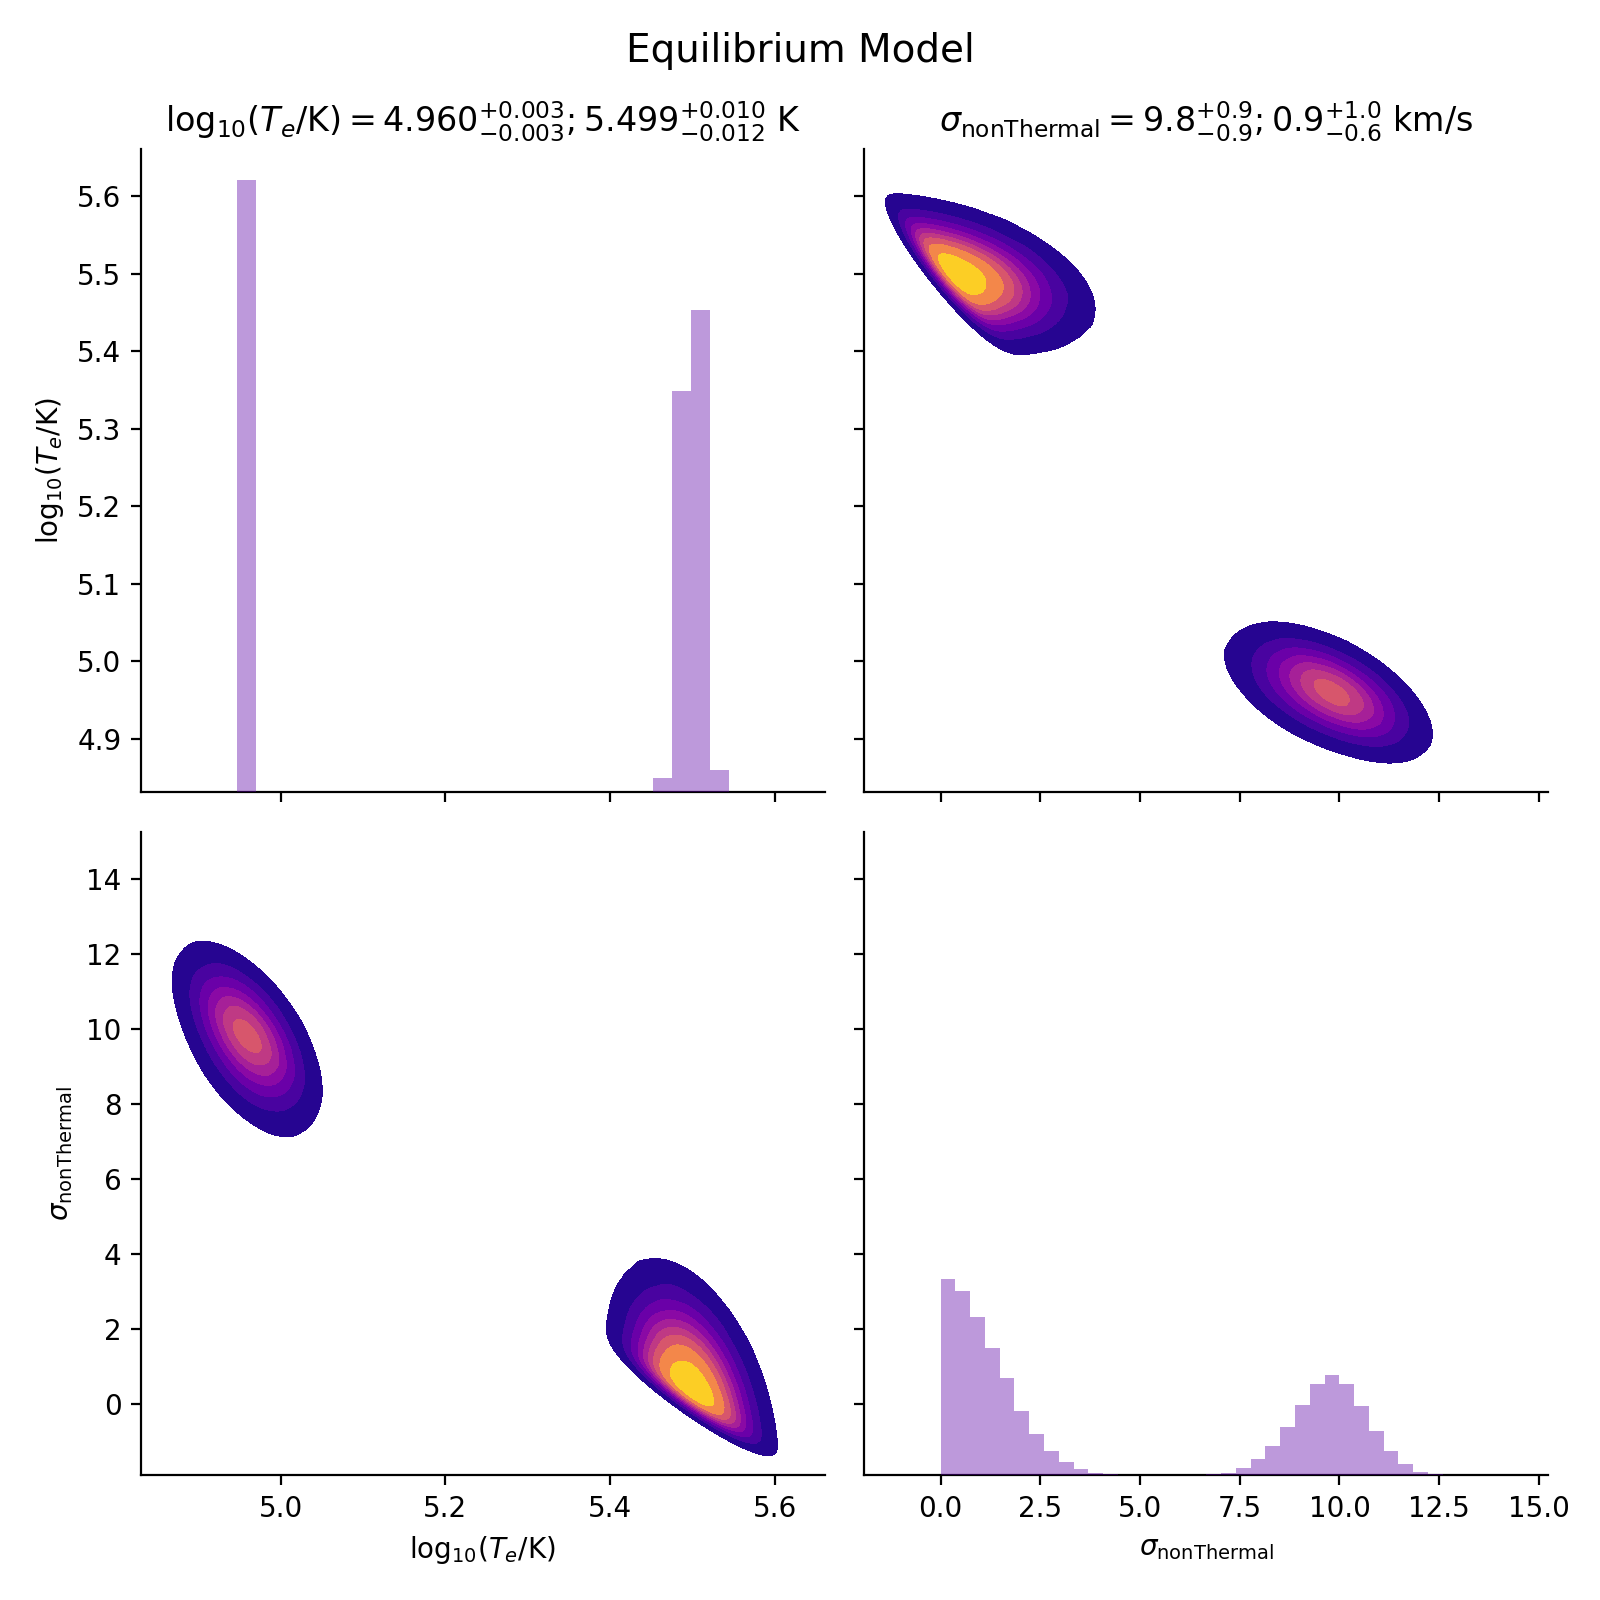

/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [19]:
cpal = sns.mpl_palette("plasma", 5)

g = sns.PairGrid(data_CIE, height = 4)
g = g.map_diag(sns.distplot, kde = False, norm_hist = False, color = cpal[0])
# sns.distplot(data["T_e"], ax = g.axes[0,0], norm_hist = False, color = cpal[-1], kde = False)
# sns.distplot(data["turbulence"], ax = g.axes[1,1], norm_hist = False, color = cpal[0], kde =False)
g = g.map_upper(sns.kdeplot, cmap = "plasma", shade = True, thresh = 0.05)
g = g.map_lower(sns.kdeplot, cmap = "plasma", shade = True, thresh = 0.05)

T_est_1 = np.percentile(data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                        (16, 50, 84))
turb_est_1 = np.percentile(data_CIE[r"$\sigma_\mathrm{nonThermal}$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                           (16, 50, 84))

T_est_2 = np.percentile(data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                        (16, 50, 84))
turb_est_2 = np.percentile(data_CIE[r"$\sigma_\mathrm{nonThermal}$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                           (16, 50, 84))


ax = g.axes[0][0]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# # ax.set_ylabel(r"$T_e$ (K)", fontsize = 16)
# for ell,est in enumerate(T_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.9, zorder = 2)

# ax.set_ylim(ylim)
# ax.set_xlim(xlim)

ax.set_title(r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}; {3:.3f}^{{+{4:.3f}}}_{{-{5:.3f}}}$ K ".format(T_est_1[1], 
                                                       T_est_1[2] - T_est_1[1], 
                                                       T_est_1[1] - T_est_1[0],
                                                                                             T_est_2[1], 
                                                       T_est_2[2] - T_est_2[1], 
                                                       T_est_2[1] - T_est_2[0]), 
             fontsize = 12)




ax = g.axes[0][1]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# for ell,est in enumerate(turb_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.7, zorder = 2)
# for ell,est in enumerate(T_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot(xlim, [est,est], lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.7, zorder = 2)
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)

ax.set_title(r"$\sigma_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}; {3:.1f}^{{+{4:.1f}}}_{{-{5:.1f}}}$ km/s".format(turb_est_1[1], 
                                                                              turb_est_1[2] - turb_est_1[1], 
                                                                              turb_est_1[1] - turb_est_1[0],
                                                                                              turb_est_2[1], 
                                                                              turb_est_2[2] - turb_est_2[1], 
                                                                              turb_est_2[1] - turb_est_2[0]), 
             fontsize = 12)

# ax = g.axes[1][1]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# # ax.set_xlabel("$\sigma_{{nonThermal}}$ (km/s)", fontsize = 16)
# for ell,est in enumerate(turb_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.9, zorder = 2)
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)





g.fig.suptitle("Equilibrium Model", fontsize = 14)


plt.tight_layout()

plt.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/CIE_MCMC_TempModel_FlatPrior.png", 
            dpi = 300, transparent = True)

In [170]:
# ISOBaric

In [15]:
pos = np.random.rand(150,2) * [5.8-4.1,25]
pos[:,0] += 4.1
nwalkers, ndim = pos.shape

with Pool() as pool:

    sampler_ISOB = emcee.EnsembleSampler(nwalkers, 
                                    ndim, 
                                    log_prob_ISOB, 
                                        pool = pool)
    sampler_ISOB.run_mcmc(pos, 10000, 
                     progress=True)


100%|█████████████████████████████████████| 10000/10000 [03:55<00:00, 42.53it/s]


<IPython.core.display.Javascript object>


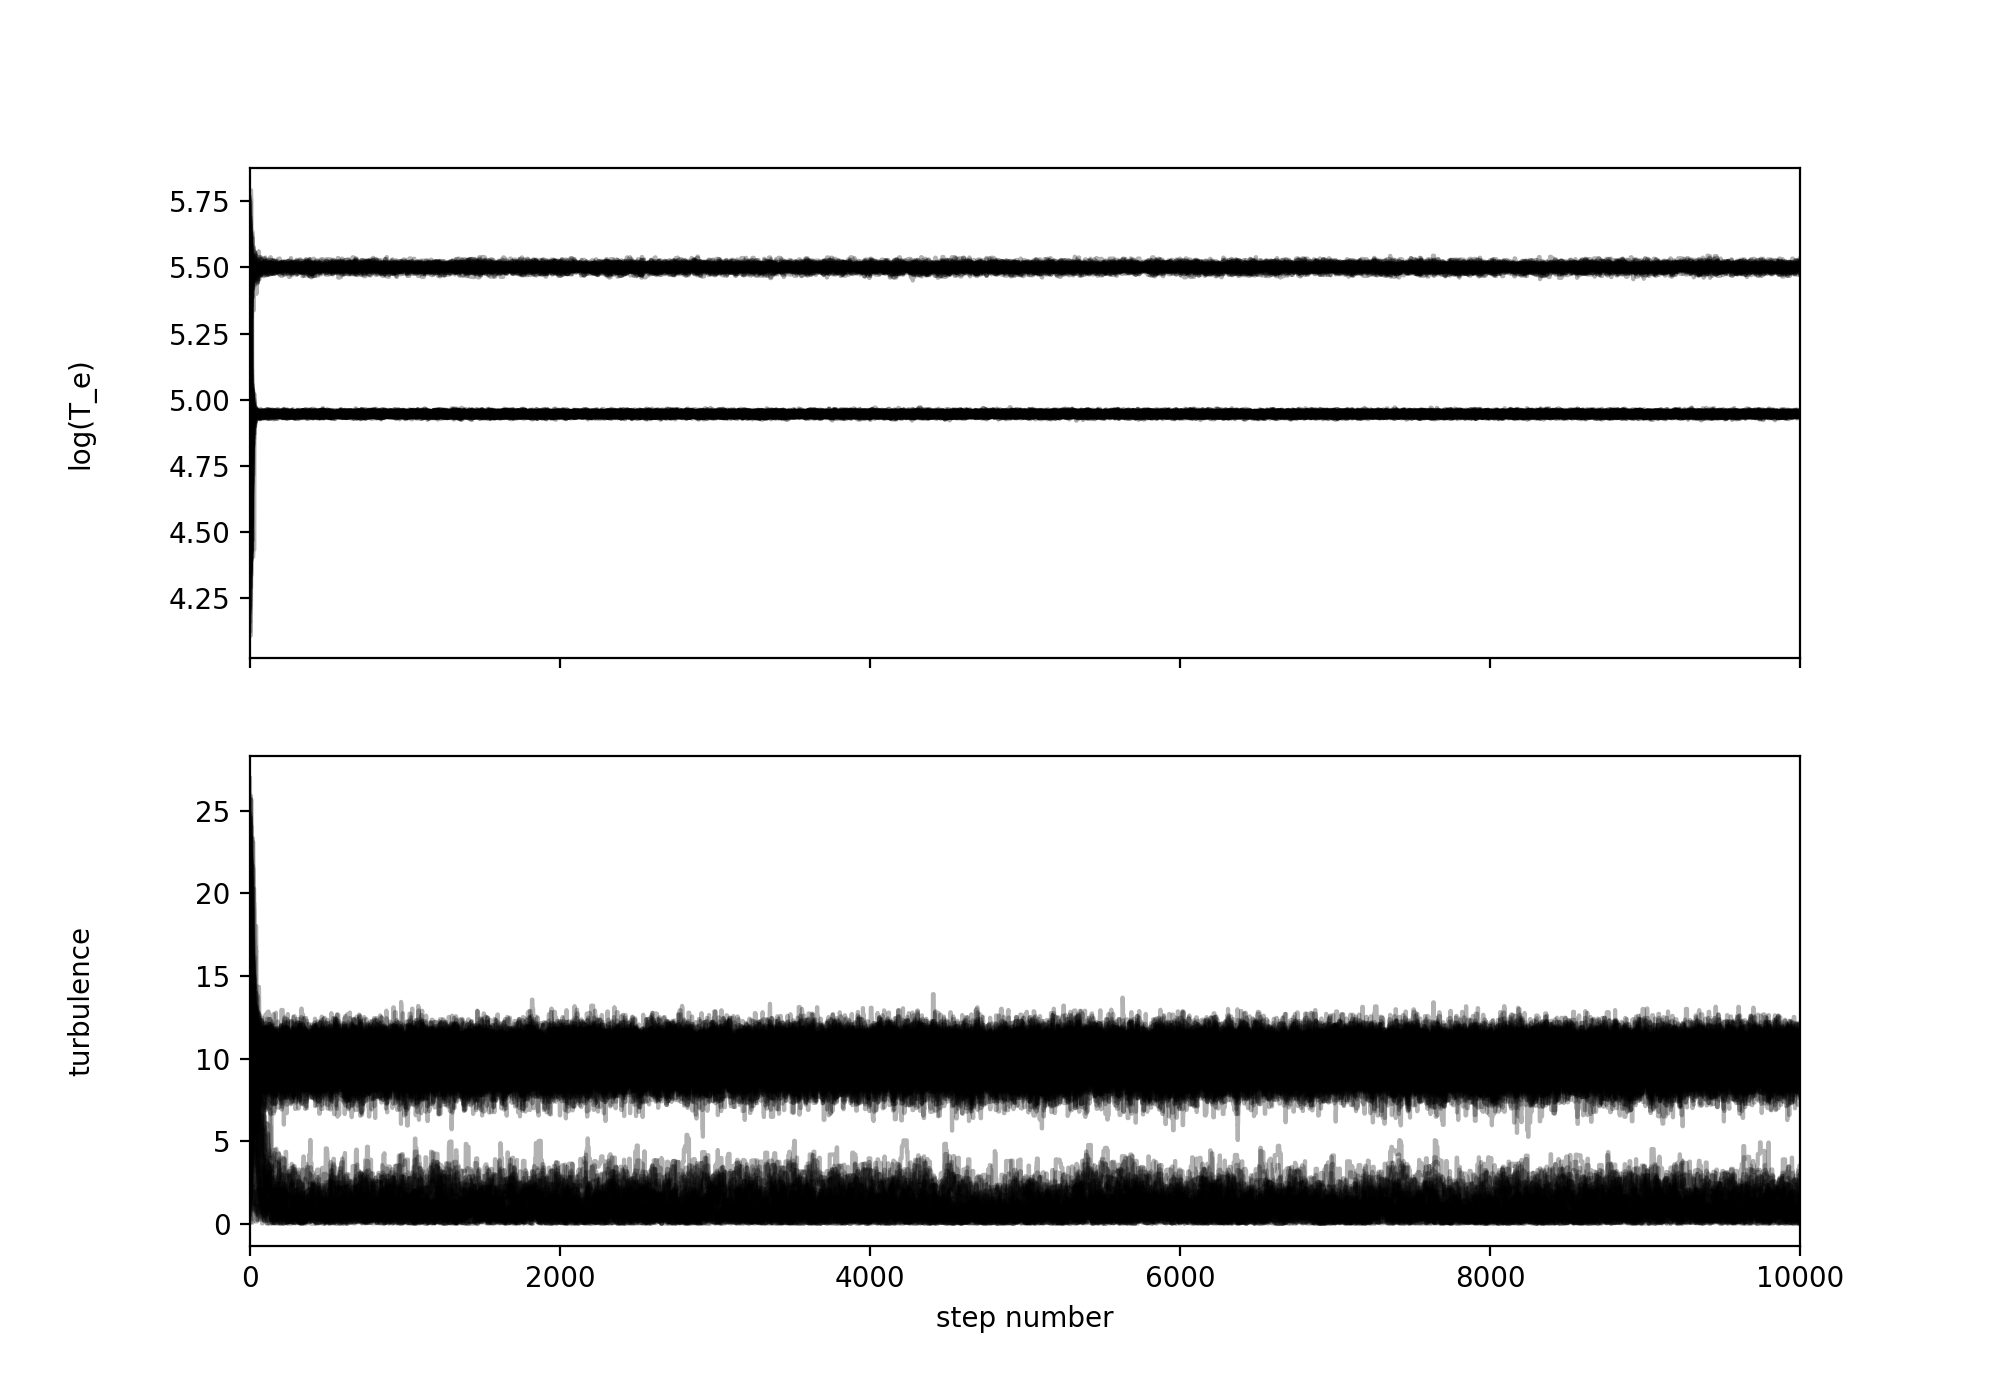

In [20]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples_ISOB = sampler_ISOB.get_chain()
labels = ["log(T_e)", "turbulence"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_ISOB[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_ISOB))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
flat_samples_ISOB = sampler_ISOB.get_chain(discard=100, thin=15, flat=True)
data_ISOB = df(flat_samples_ISOB, columns=[r"$\log_{10}(T_e/\mathrm{K})$", r"$\sigma_\mathrm{nonThermal}$"])

<IPython.core.display.Javascript object>


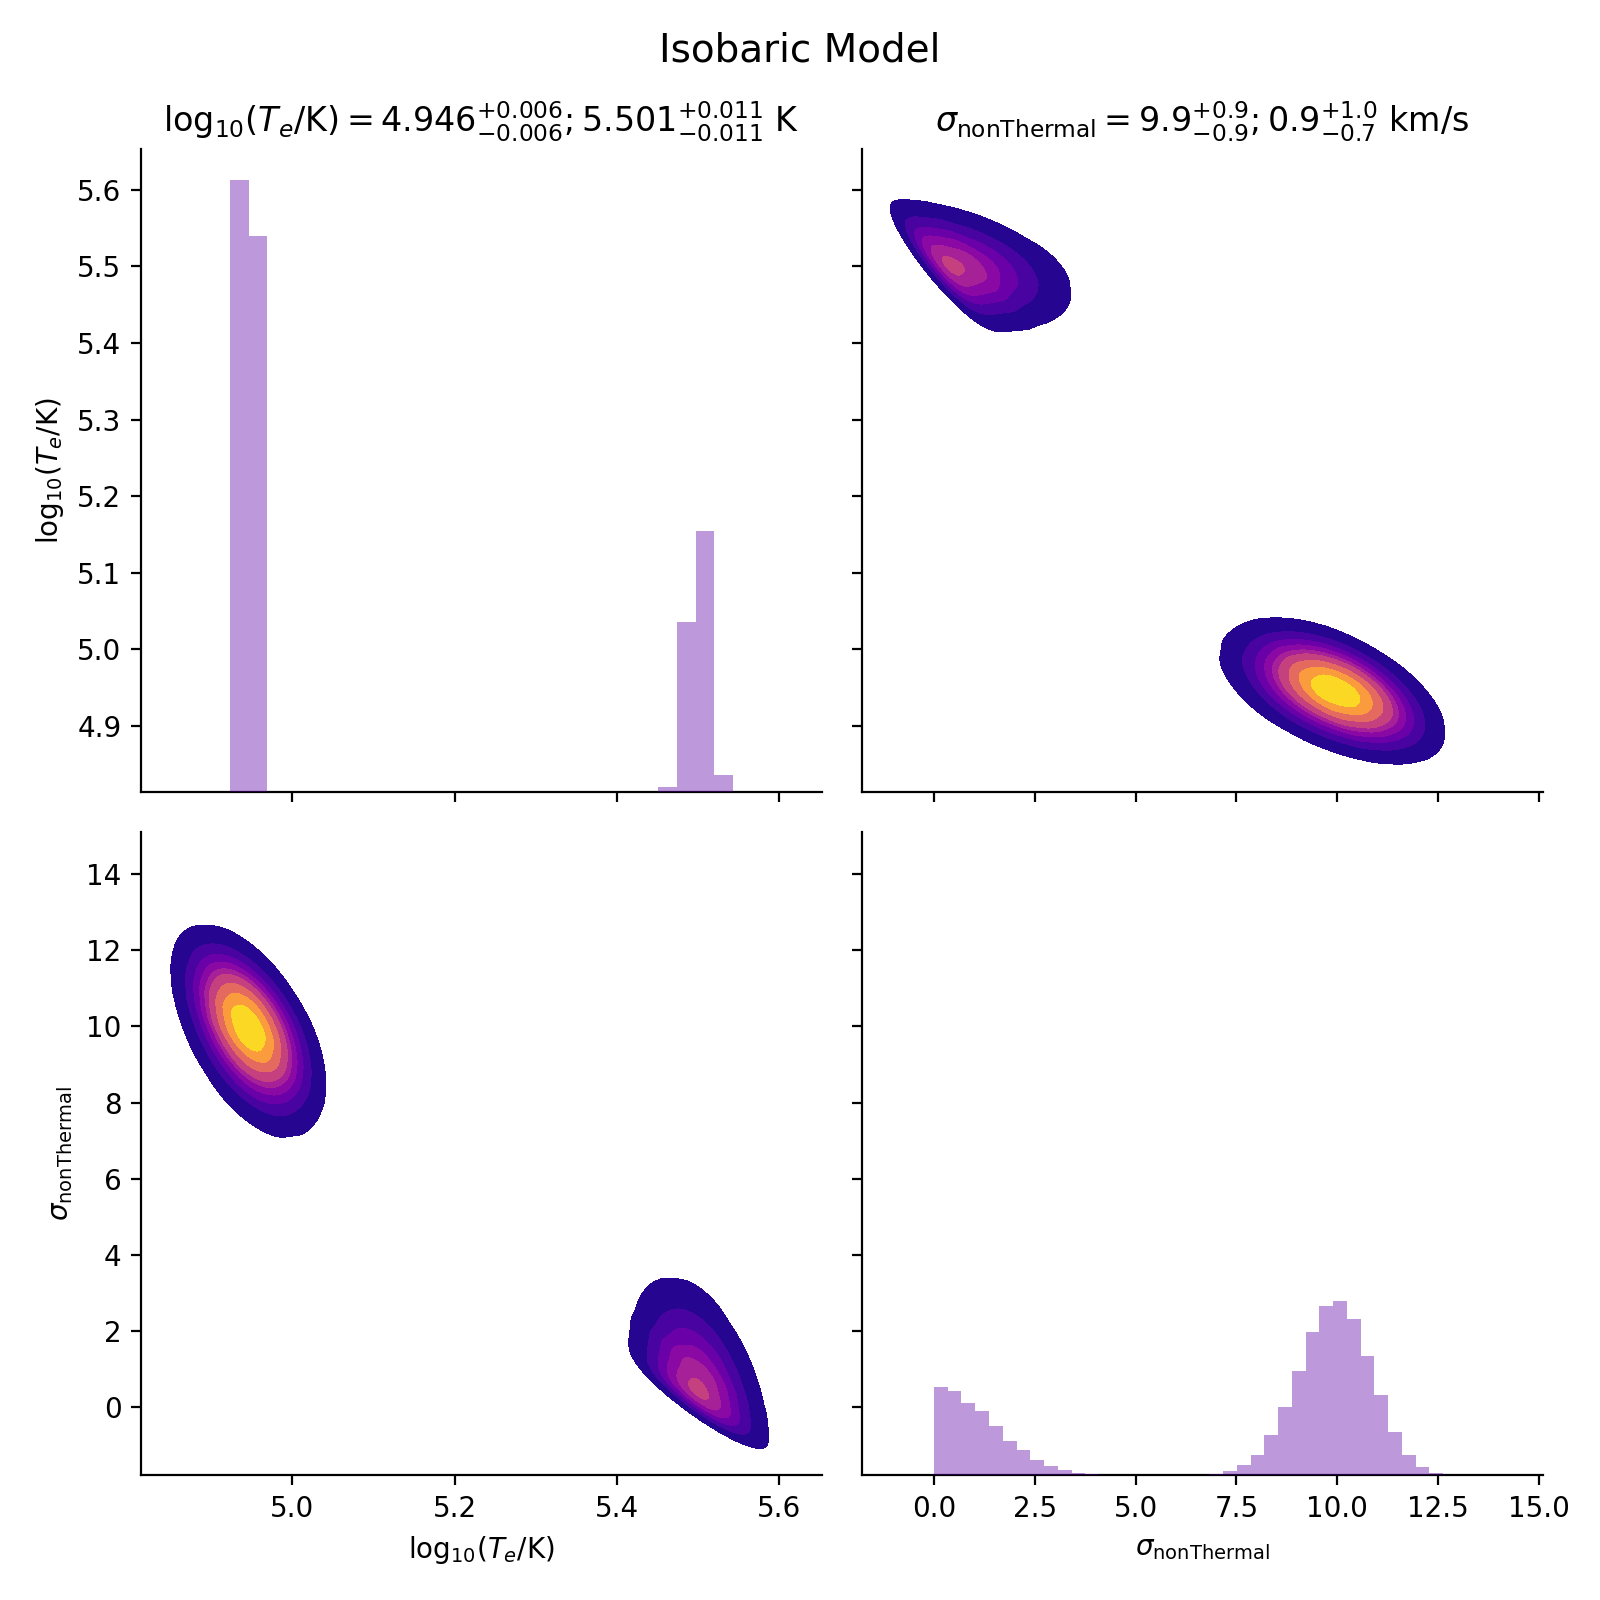

/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [22]:
cpal = sns.mpl_palette("plasma", 5)

g = sns.PairGrid(data_ISOB, height = 4)
g = g.map_diag(sns.distplot, kde = False, norm_hist = False, color = cpal[0])
# sns.distplot(data["T_e"], ax = g.axes[0,0], norm_hist = False, color = cpal[-1], kde = False)
# sns.distplot(data["turbulence"], ax = g.axes[1,1], norm_hist = False, color = cpal[0], kde =False)
g = g.map_upper(sns.kdeplot, cmap = "plasma", shade = True, thresh = 0.05)
g = g.map_lower(sns.kdeplot, cmap = "plasma", shade = True, thresh = 0.05)

T_est_1 = np.percentile(data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                        (16, 50, 84))
turb_est_1 = np.percentile(data_ISOB[r"$\sigma_\mathrm{nonThermal}$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                           (16, 50, 84))

T_est_2 = np.percentile(data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                        (16, 50, 84))
turb_est_2 = np.percentile(data_ISOB[r"$\sigma_\mathrm{nonThermal}$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                           (16, 50, 84))


ax = g.axes[0][0]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# # ax.set_ylabel(r"$T_e$ (K)", fontsize = 16)
# for ell,est in enumerate(T_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.9, zorder = 2)

# ax.set_ylim(ylim)
# ax.set_xlim(xlim)

ax.set_title(r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}; {3:.3f}^{{+{4:.3f}}}_{{-{5:.3f}}}$ K ".format(T_est_1[1], 
                                                       T_est_1[2] - T_est_1[1], 
                                                       T_est_1[1] - T_est_1[0],
                                                                                             T_est_2[1], 
                                                       T_est_2[2] - T_est_2[1], 
                                                       T_est_2[1] - T_est_2[0]), 
             fontsize = 12)




ax = g.axes[0][1]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# for ell,est in enumerate(turb_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.7, zorder = 2)
# for ell,est in enumerate(T_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot(xlim, [est,est], lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.7, zorder = 2)
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)

ax.set_title(r"$\sigma_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}; {3:.1f}^{{+{4:.1f}}}_{{-{5:.1f}}}$ km/s".format(turb_est_1[1], 
                                                                              turb_est_1[2] - turb_est_1[1], 
                                                                              turb_est_1[1] - turb_est_1[0],
                                                                                              turb_est_2[1], 
                                                                              turb_est_2[2] - turb_est_2[1], 
                                                                              turb_est_2[1] - turb_est_2[0]), 
             fontsize = 12)

# ax = g.axes[1][1]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# # ax.set_xlabel("$\sigma_{{nonThermal}}$ (km/s)", fontsize = 16)
# for ell,est in enumerate(turb_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.9, zorder = 2)
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)





g.fig.suptitle("Isobaric Model", fontsize = 14)


plt.tight_layout()

plt.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/ISOB_MCMC_TempModel_FlatPrior.png", 
            dpi = 300, transparent = True)

In [176]:
# Isochoric

In [16]:
pos = np.random.rand(150,2) * [5.8-4.1,25]
pos[:,0] += 4.1
nwalkers, ndim = pos.shape

with Pool() as pool:

    sampler_ISOCh = emcee.EnsembleSampler(nwalkers, 
                                    ndim, 
                                    log_prob_ISOCh, 
                                        pool = pool)
    sampler_ISOCh.run_mcmc(pos, 10000, 
                     progress=True)


100%|█████████████████████████████████████| 10000/10000 [03:54<00:00, 42.57it/s]


<IPython.core.display.Javascript object>


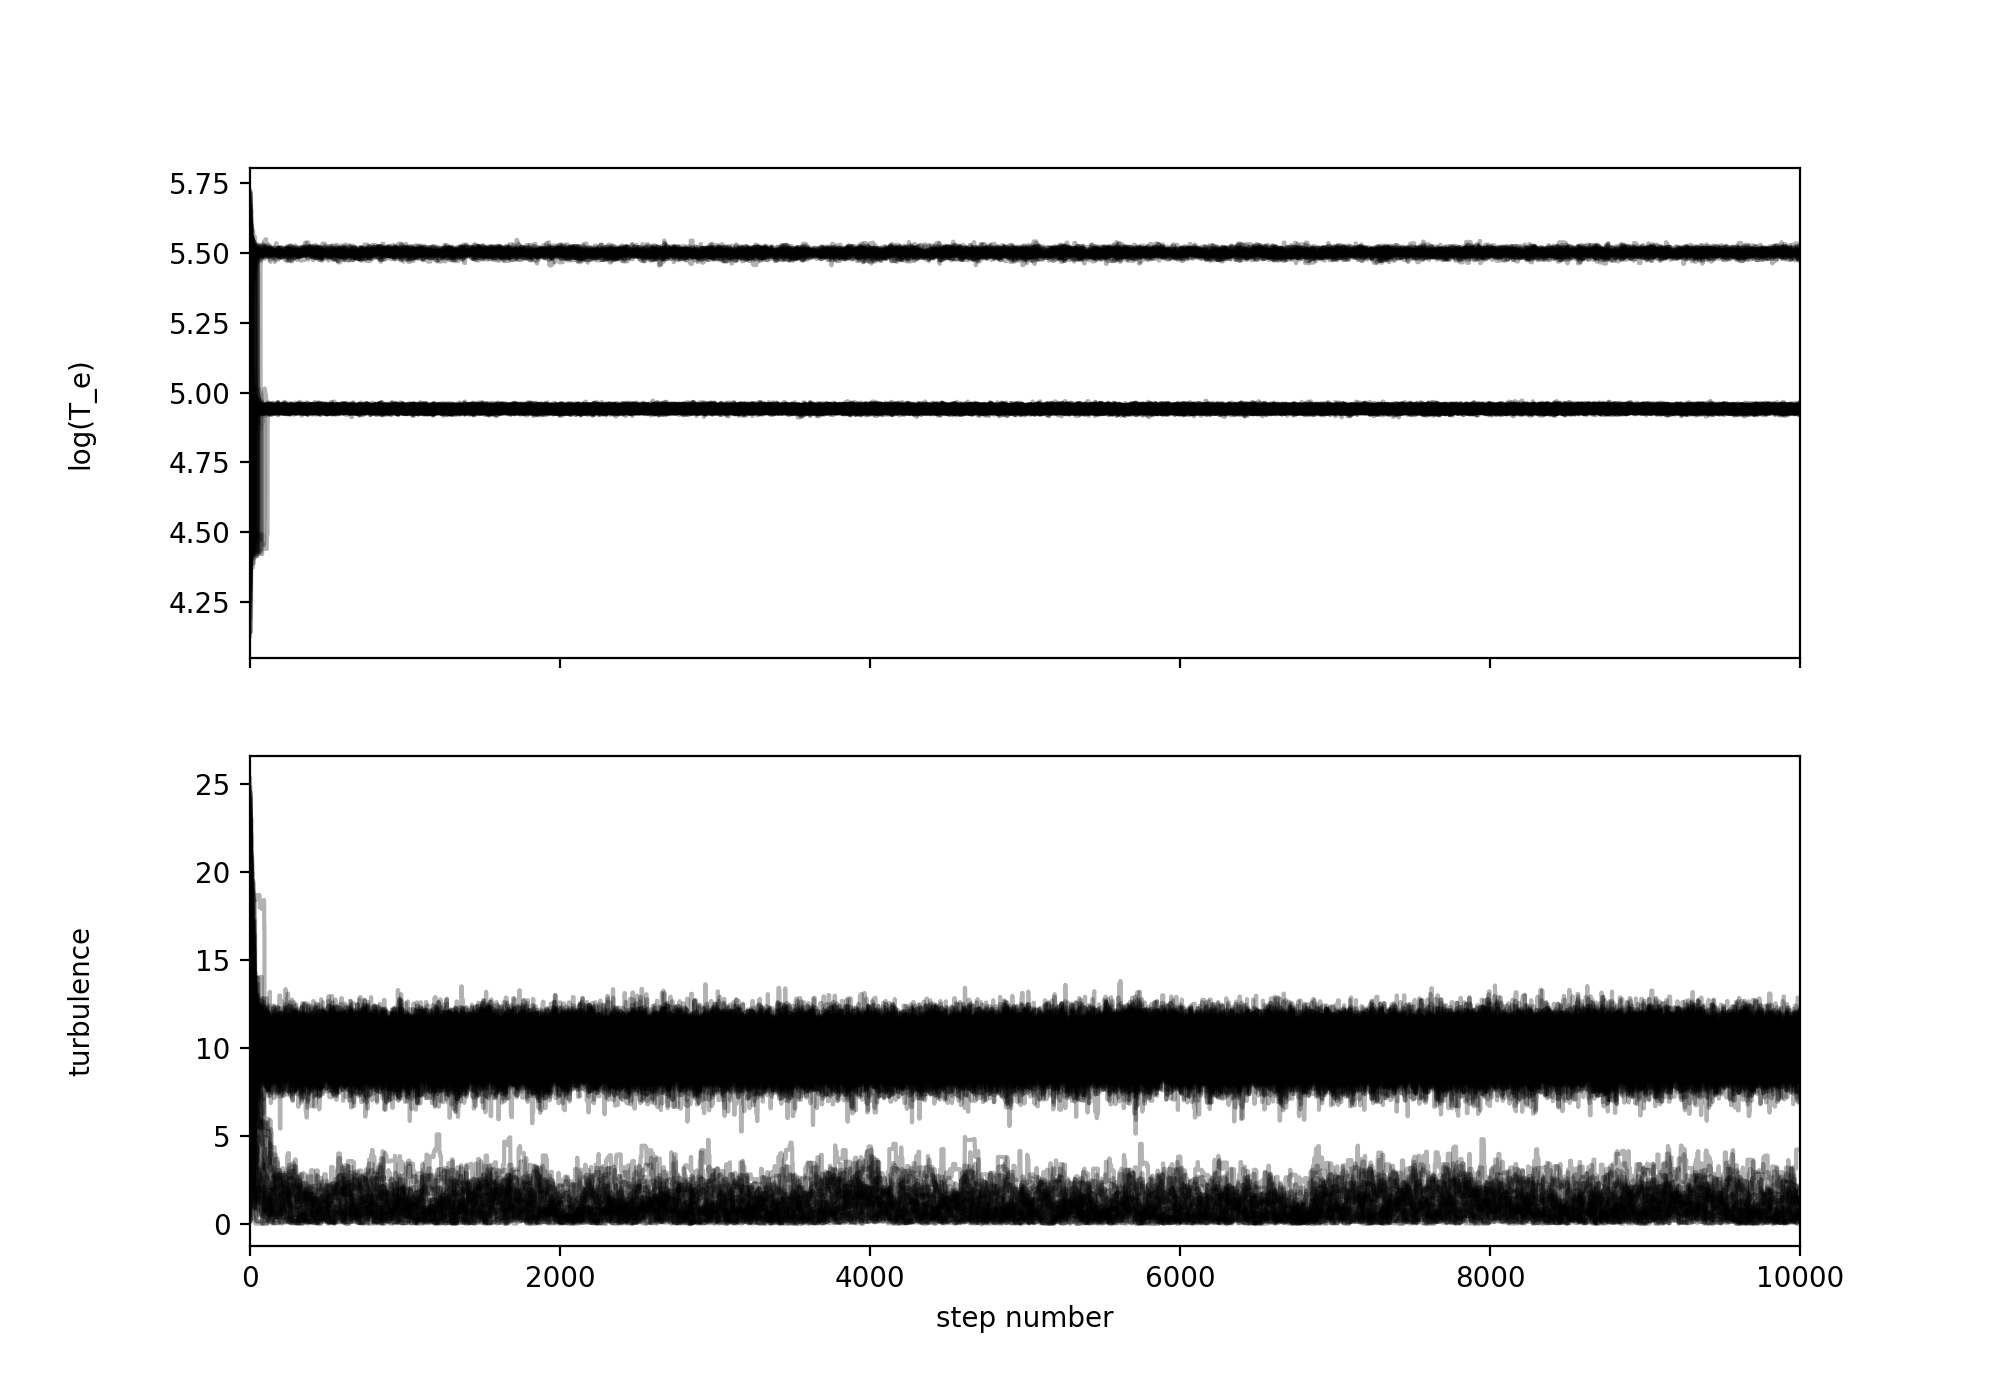

In [23]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples_ISOCh = sampler_ISOCh.get_chain()
labels = ["log(T_e)", "turbulence"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_ISOCh[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_ISOCh))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
flat_samples_ISOCh = sampler_ISOCh.get_chain(discard=100, thin=15, flat=True)
data_ISOCh = df(flat_samples_ISOCh, columns=[r"$\log_{10}(T_e/\mathrm{K})$", r"$\sigma_\mathrm{nonThermal}$"])

<IPython.core.display.Javascript object>


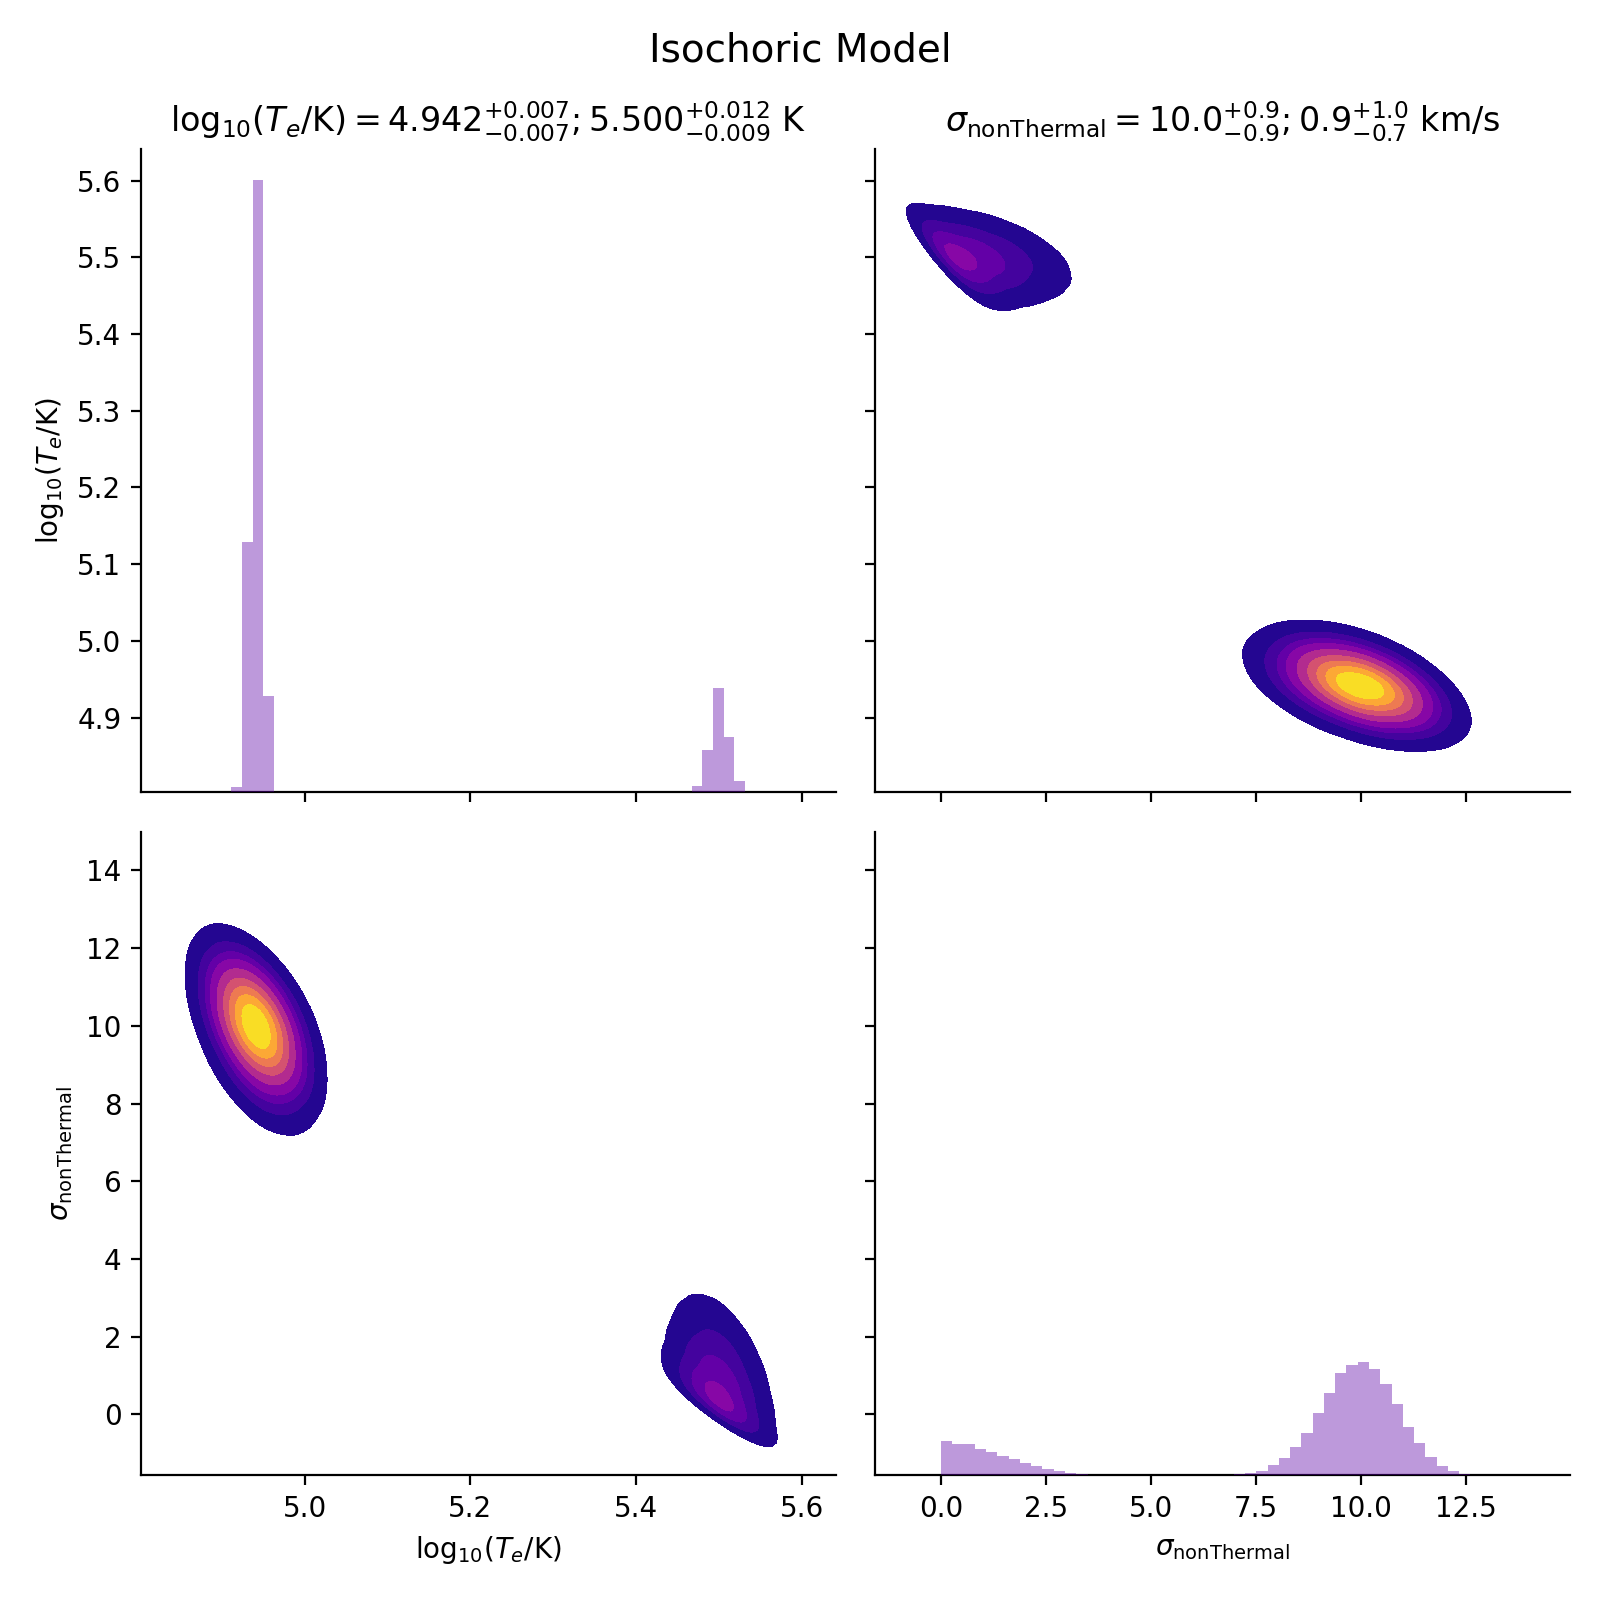

/opt/homebrew/Caskroom/miniforge/base/envs/voigtfit/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [25]:
cpal = sns.mpl_palette("plasma", 5)

g = sns.PairGrid(data_ISOCh, height = 4)
g = g.map_diag(sns.distplot, kde = False, norm_hist = False, color = cpal[0])
# sns.distplot(data["T_e"], ax = g.axes[0,0], norm_hist = False, color = cpal[-1], kde = False)
# sns.distplot(data["turbulence"], ax = g.axes[1,1], norm_hist = False, color = cpal[0], kde =False)
g = g.map_upper(sns.kdeplot, cmap = "plasma", shade = True, thresh = 0.05)
g = g.map_lower(sns.kdeplot, cmap = "plasma", shade = True, thresh = 0.05)

T_est_1 = np.percentile(data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                        (16, 50, 84))
turb_est_1 = np.percentile(data_ISOCh[r"$\sigma_\mathrm{nonThermal}$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                           (16, 50, 84))

T_est_2 = np.percentile(data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                        (16, 50, 84))
turb_est_2 = np.percentile(data_ISOCh[r"$\sigma_\mathrm{nonThermal}$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                           (16, 50, 84))


ax = g.axes[0][0]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# # ax.set_ylabel(r"$T_e$ (K)", fontsize = 16)
# for ell,est in enumerate(T_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.9, zorder = 2)

# ax.set_ylim(ylim)
# ax.set_xlim(xlim)

ax.set_title(r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}; {3:.3f}^{{+{4:.3f}}}_{{-{5:.3f}}}$ K ".format(T_est_1[1], 
                                                       T_est_1[2] - T_est_1[1], 
                                                       T_est_1[1] - T_est_1[0],
                                                                                             T_est_2[1], 
                                                       T_est_2[2] - T_est_2[1], 
                                                       T_est_2[1] - T_est_2[0]), 
             fontsize = 12)




ax = g.axes[0][1]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# for ell,est in enumerate(turb_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.7, zorder = 2)
# for ell,est in enumerate(T_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot(xlim, [est,est], lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.7, zorder = 2)
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)

ax.set_title(r"$\sigma_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}; {3:.1f}^{{+{4:.1f}}}_{{-{5:.1f}}}$ km/s".format(turb_est_1[1], 
                                                                              turb_est_1[2] - turb_est_1[1], 
                                                                              turb_est_1[1] - turb_est_1[0],
                                                                                              turb_est_2[1], 
                                                                              turb_est_2[2] - turb_est_2[1], 
                                                                              turb_est_2[1] - turb_est_2[0]), 
             fontsize = 12)

# ax = g.axes[1][1]
# ylim = ax.get_ylim()
# xlim = ax.set_xlim()
# # ax.set_xlabel("$\sigma_{{nonThermal}}$ (km/s)", fontsize = 16)
# for ell,est in enumerate(turb_est):
#     lws = {0:2, 1:4, 2:2}
#     lss = {0:"--", 1:"-", 2:"--"}
#     ax.plot([est,est], ylim, lw = lws[ell], ls = lss[ell], color = cpal[-1], alpha = 0.9, zorder = 2)
# ax.set_ylim(ylim)
# ax.set_xlim(xlim)





g.fig.suptitle("Isochoric Model", fontsize = 14)


plt.tight_layout()

plt.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/ISOCh_MCMC_TempModel_FlatPrior.png", 
            dpi = 300, transparent = True)

In [26]:
# summary Plot

<IPython.core.display.Javascript object>


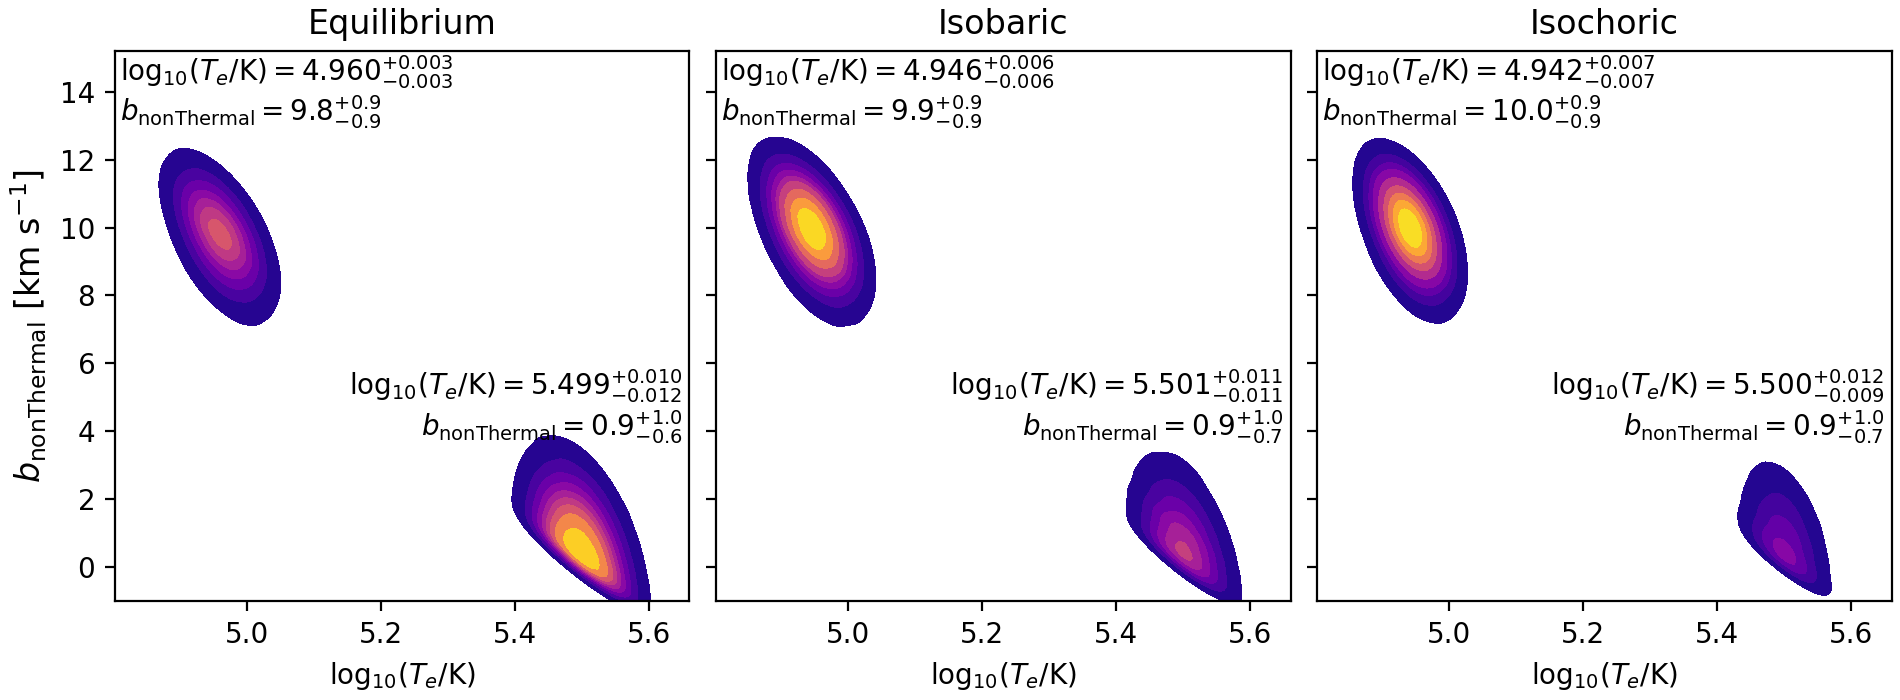

In [102]:
fig,axs = plt.subplots(1,3, constrained_layout = True, 
                       sharex = True, sharey = True,
                       figsize = (9.5,3.5))

# Isochoric
ax = axs[2]

T_est_1 = np.percentile(data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                        (16, 50, 84))
turb_est_1 = np.percentile(data_ISOCh[r"$\sigma_\mathrm{nonThermal}$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                           (16, 50, 84))

T_est_2 = np.percentile(data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                        (16, 50, 84))
turb_est_2 = np.percentile(data_ISOCh[r"$\sigma_\mathrm{nonThermal}$"][data_ISOCh[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                           (16, 50, 84))


sns.kdeplot(data = data_ISOCh, 
            x = r"$\log_{10}(T_e/\mathrm{K})$", 
            y = r"$\sigma_\mathrm{nonThermal}$",
            ax = ax, 
            cmap = "plasma", 
            shade = True, 
            thresh = 0.05)

ax.text(4.81, 12.83, 
        r"$b_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(turb_est_1[1], 
                                                                              turb_est_1[2] - turb_est_1[1], 
                                                                              turb_est_1[1] - turb_est_1[0]),
       ha = "left", va = "bottom",)


ax.text(4.81, 12.83+1.2, 
        r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(T_est_1[1], 
                                                                              T_est_1[2] - T_est_1[1], 
                                                                              T_est_1[1] - T_est_1[0]),
       ha = "left", va = "bottom",)


ax.text(5.65, 3.58, 
        r"$b_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(turb_est_2[1], 
                                                                              turb_est_2[2] - turb_est_2[1], 
                                                                              turb_est_2[1] - turb_est_2[0]),
       ha = "right", va = "bottom",)


ax.text(5.65, 3.58+1.2, 
        r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(T_est_2[1], 
                                                                              T_est_2[2] - T_est_2[1], 
                                                                              T_est_2[1] - T_est_2[0]),
       ha = "right", va = "bottom",)

ax.set_title("Isochoric", fontsize = 12)



# Isobaric
ax = axs[1]

T_est_1 = np.percentile(data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                        (16, 50, 84))
turb_est_1 = np.percentile(data_ISOB[r"$\sigma_\mathrm{nonThermal}$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                           (16, 50, 84))

T_est_2 = np.percentile(data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                        (16, 50, 84))
turb_est_2 = np.percentile(data_ISOB[r"$\sigma_\mathrm{nonThermal}$"][data_ISOB[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                           (16, 50, 84))


sns.kdeplot(data = data_ISOB, 
            x = r"$\log_{10}(T_e/\mathrm{K})$", 
            y = r"$\sigma_\mathrm{nonThermal}$",
            ax = ax, 
            cmap = "plasma", 
            shade = True, 
            thresh = 0.05)

ax.text(4.81, 12.83, 
        r"$b_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(turb_est_1[1], 
                                                                              turb_est_1[2] - turb_est_1[1], 
                                                                              turb_est_1[1] - turb_est_1[0]),
       ha = "left", va = "bottom",)


ax.text(4.81, 12.83+1.2, 
        r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(T_est_1[1], 
                                                                              T_est_1[2] - T_est_1[1], 
                                                                              T_est_1[1] - T_est_1[0]),
       ha = "left", va = "bottom",)


ax.text(5.65, 3.58, 
        r"$b_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(turb_est_2[1], 
                                                                              turb_est_2[2] - turb_est_2[1], 
                                                                              turb_est_2[1] - turb_est_2[0]),
       ha = "right", va = "bottom",)


ax.text(5.65, 3.58+1.2, 
        r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(T_est_2[1], 
                                                                              T_est_2[2] - T_est_2[1], 
                                                                              T_est_2[1] - T_est_2[0]),
       ha = "right", va = "bottom",)

ax.set_title("Isobaric", fontsize = 12)


# Equil
ax = axs[0]

T_est_1 = np.percentile(data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                        (16, 50, 84))
turb_est_1 = np.percentile(data_CIE[r"$\sigma_\mathrm{nonThermal}$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]<5.2], 
                           (16, 50, 84))

T_est_2 = np.percentile(data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                        (16, 50, 84))
turb_est_2 = np.percentile(data_CIE[r"$\sigma_\mathrm{nonThermal}$"][data_CIE[r"$\log_{10}(T_e/\mathrm{K})$"]>5.2], 
                           (16, 50, 84))


sns.kdeplot(data = data_CIE, 
            x = r"$\log_{10}(T_e/\mathrm{K})$", 
            y = r"$\sigma_\mathrm{nonThermal}$",
            ax = ax, 
            cmap = "plasma", 
            shade = True, 
            thresh = 0.05)

ax.text(4.81, 12.83, 
        r"$b_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(turb_est_1[1], 
                                                                              turb_est_1[2] - turb_est_1[1], 
                                                                              turb_est_1[1] - turb_est_1[0]),
       ha = "left", va = "bottom",)


ax.text(4.81, 12.83+1.2, 
        r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(T_est_1[1], 
                                                                              T_est_1[2] - T_est_1[1], 
                                                                              T_est_1[1] - T_est_1[0]),
       ha = "left", va = "bottom",)


ax.text(5.65, 3.58, 
        r"$b_\mathrm{{nonThermal}} = {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(turb_est_2[1], 
                                                                              turb_est_2[2] - turb_est_2[1], 
                                                                              turb_est_2[1] - turb_est_2[0]),
       ha = "right", va = "bottom",)


ax.text(5.65, 3.58+1.2, 
        r"$\log_{{10}}(T_e/\mathrm{{K}}) = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(T_est_2[1], 
                                                                              T_est_2[2] - T_est_2[1], 
                                                                              T_est_2[1] - T_est_2[0]),
       ha = "right", va = "bottom",)

ax.set_title("Equilibrium", fontsize = 12)

ax.set_ylim(-1,15.2)

ax.set_ylabel(r"$b_\mathrm{nonThermal}~[\mathrm{km~s}^{-1}]$", fontsize = 12)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/MCMC_TempModel_Combined.png", 
            dpi = 300, transparent = True)


# Combination Impact

In [82]:
# Scenario 2
log_T1, log_T1_err = 5.5, 0.01
log_T2, log_T2_err = 4.9, 0.01

HII_mask = np.isinf(CIE["LOG_HII/CIV"])

CIE_HII_CIV_interper = interp1d(np.log10(CIE["T"].value[~HII_mask]), 
                                CIE["LOG_HII/CIV"][~HII_mask], 
                                fill_value = np.nan, 
                                bounds_error = False)

In [83]:
N_comps = 100
log_N_HII = 19.
frac_T1 = np.linspace(0,1,100)

CIV_cols = []
SiIV_cols = []

for frac in frac_T1:
    N_T1 = int(frac * N_comps)
    if N_T1 == 0:
        T2s = log_T2 + log_T2_err*np.random.randn(N_comps)
        CIV_cols.append(log_N_HII - CIE_HII_CIV_interper(T2s))
        SiIV_cols.append(CIV_cols[-1] - CIE_interper(T2s))
    elif N_T1 == N_comps:
        T1s = log_T1 + log_T1_err*np.random.randn(N_comps)
        CIV_cols.append(log_N_HII - CIE_HII_CIV_interper(T1s))
        SiIV_cols.append(CIV_cols[-1] - CIE_interper(T1s))
    else:
        T1s = log_T1 + log_T1_err*np.random.randn(N_T1)
        T2s = log_T2 + log_T2_err*np.random.randn(N_comps - N_T1)
        CIV_cols.append(log_N_HII - CIE_HII_CIV_interper(np.concatenate([T1s,T2s])))
        SiIV_cols.append(CIV_cols[-1] - CIE_interper(np.concatenate([T1s,T2s])))
        
CIV_cols = np.array(CIV_cols)
SiIV_cols = np.array(SiIV_cols)

summed_CIV_cols = np.log10(np.nansum(10**CIV_cols, axis = 1))
summed_SiIV_cols = np.log10(np.nansum(10**SiIV_cols, axis = 1))

res_CIV_SiIV_ratio = summed_CIV_cols - summed_SiIV_cols

<IPython.core.display.Javascript object>


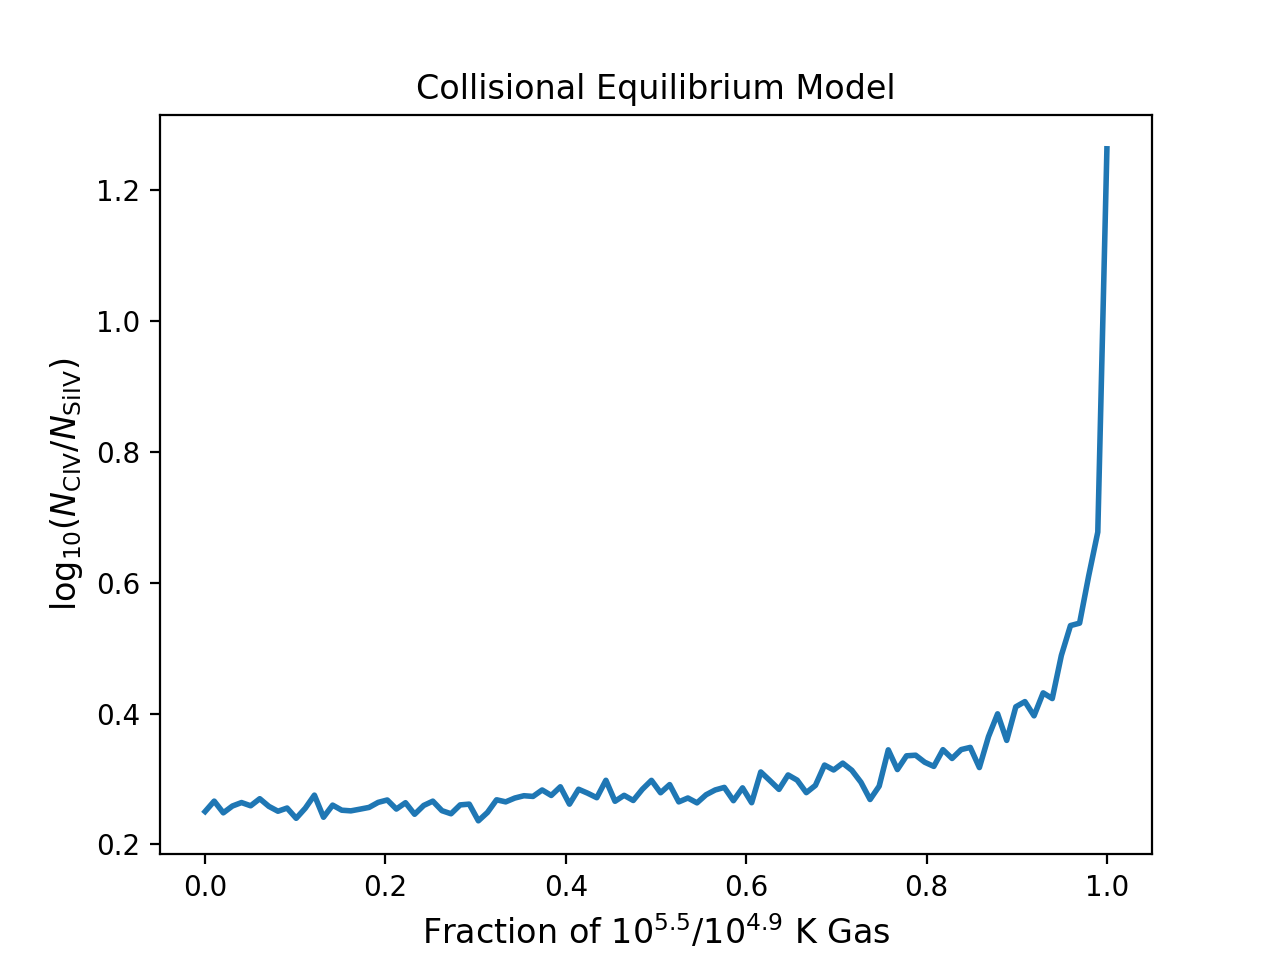

Text(0.5, 1.0, 'Collisional Equilibrium Model')

In [84]:
fig,ax = plt.subplots()

ax.plot(frac_T1, res_CIV_SiIV_ratio, lw = 2)

ax.set_xlabel(r"Fraction of $10^{5.5} / 10^{4.9}$ K Gas", fontsize = 12)
ax.set_ylabel(r"$\log_{10}(N_\mathrm{C IV} / N_\mathrm{Si IV})$", fontsize = 12)

ax.set_title("Collisional Equilibrium Model", fontsize = 12)



In [57]:
CIE_interper(4.9)

array(0.24930768)

In [100]:
line_width(10**5.5*u.K, 16*u.u, 5*u.km/u.s)

<Quantity 26.59541286 km / s>

In [105]:
np.log10(2.5*1e5)

5.3979400086720375

In [108]:
10**11.4

251188643150.95822